# Исследование надежности заемщиков


Заказчик — кредитный отдел банка. Нужно разобраться, какие факторы влияют на погашение кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Изучение общей информации о данных

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#изучим общую информацию о файле:
data = pd.read_csv('downloads/data.csv')

In [3]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В датасете присутсвуют пропуски в двух столбцах - трудовом стаже и ежемесячном доходе заемщиков.

## Предобработка данных

### Удаление пропусков

In [5]:
#подсчитаем количество пропусков:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Число тех, у кого отсуствуют значения в графе с ежемесячным доходом, совпадает с числом тех, у кого отсутствует трудовой стаж. Возможно, эти люди никогда не работали, либо никогда не работали официально.

In [6]:
#заменим пропуски в столбце с ежемесячным доходом медианой дохода по типу занятости:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 
             'total_income'
            ] = data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

In [7]:
#првоерим, какие значения присутствуют в стобце с трудовым стажем:
data['days_employed'].unique()

array([-8437.67302776, -4024.80375385, -5623.42261023, ...,
       -2113.3468877 , -3112.4817052 , -1984.50758853])

Столбец содержит отрицательные значения, что в принципе невозможно - трудовой стаж не может быть меньше нуля.

In [8]:
#приведем все значения столбца с трудовым стажем в положительные:
data['days_employed'] = data['days_employed'].abs()

In [9]:
#рассмотрим трудовой стаж по разным типам занятости:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У безработных и пенсионеров наблюдается аномально большой стаж. Рассмотрим эти значения поподробнее:

In [10]:
#отфильтруем безработных и пенсионеров отдельно:
data_unemp = data[data['income_type'] == 'безработный']
data_pens = data[data['income_type'] == 'пенсионер']

In [11]:
data_unemp['days_employed'].describe()

count         2.000000
mean     366413.652744
std       40855.478519
min      337524.466835
25%      351969.059790
50%      366413.652744
75%      380858.245699
max      395302.838654
Name: days_employed, dtype: float64

In [12]:
data_pens['days_employed'].describe()

count      3443.000000
mean     365003.491245
std       21069.606065
min      328728.720605
25%      346649.346146
50%      365213.306266
75%      383231.396871
max      401755.400475
Name: days_employed, dtype: float64

Все значения трудового стажа для этих двух категорий слишком большие. При этом не очень понятно, какой именно стаж должен быть у этих заемщиков, поэтому оставим данные как есть.

In [13]:
#проверим, какие значения встречаются в столбце с количеством детей:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

In [14]:
#удалим артефакты:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [15]:
#заменим пропуски в трудовом стаже медианой по типу занятости:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 
             'days_employed'
            ] = data.loc[(data['income_type'] == t), 'days_employed'].median()

In [16]:
#подсчитаем пропуски еще раз:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Пропусков больше не осталось.

In [17]:
#подсчитаем дубликаты:
data.duplicated().sum()

54

In [18]:
#удалим дубликаты:
data = data.drop_duplicates()

In [19]:
#значения в столбце с уровнем образования записаны в разных регистрах. Исправим это:
data['education'] = data['education'].str.lower()

In [20]:
#напишем функцию, назначающую категории дохода в зависимости от уровня заработка:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [21]:
#применим функцию:
data['total_income_category'] = data['total_income'].apply(categorize_income)

In [22]:
#посмотрим, на какие цели берут кредит:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [23]:
#напишем функцию, которая назначает категории разным целям кредита:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [24]:
#применим функцию:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

In [33]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,B,операции с недвижимостью
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,C,операции с автомобилем
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,C,операции с недвижимостью
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,B,получение образования
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,C,проведение свадьбы


## Исследуйте данные и ответьте на вопросы

In [25]:
#построим сводную таблицу, рассчитав в ней долю должников по количеству детей:
data_pivot = data.pivot_table(index=['children'], values="debt", aggfunc=['sum', 'count', 'mean'])
data_pivot.columns = ['sum', 'count', 'mean']
data_pivot = data_pivot.reset_index()
data_pivot

,children,sum,count,mean
0,0,1063,14107,0.075353
1,1,444,4809,0.092327
2,2,194,2052,0.094542
3,3,27,330,0.081818
4,4,4,41,0.097561
5,5,0,9,0.000000


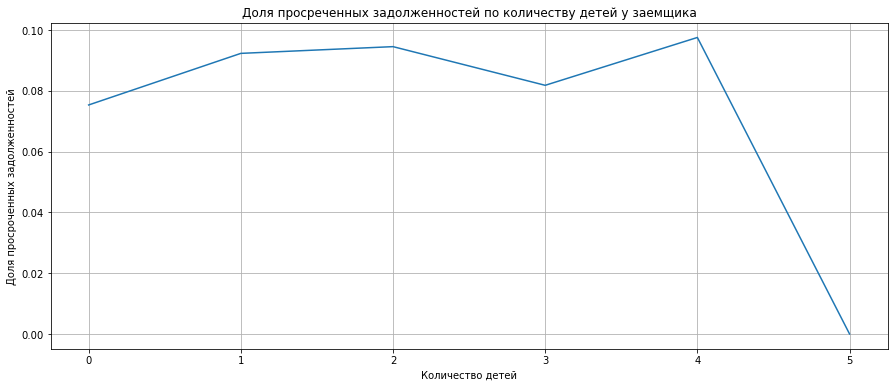

In [26]:
#построим график:
plt.figure(figsize=(15, 6))
plt.plot(data_pivot['children'], data_pivot['mean'])
plt.grid()
plt.title('Доля просреченных задолженностей по количеству детей у заемщика')
plt.xlabel('Количество детей')
plt.ylabel('Доля просроченных задолженностей');

**Вывод:** С увеличением количества детей вероятность просроченной задолженности немного возрастает. Чаще всего возвращают кредит в срок те, у кого нет детей. Отсутствие просроченных задолженностей у людей с пятью детьми может быть связано с маленькой выборкой - таких клиентов всего 9 человек.

In [27]:
#Подсчитаем долю клиентов с просроченной задолженностью в зависимости от семейного положения:
data_pivot1 = data.pivot_table(index=['family_status'], values="debt", aggfunc=['sum', 'count', 'mean'])
data_pivot1.columns = ['sum', 'count', 'mean']
data_pivot1 = data_pivot1.sort_values(by='mean', ascending=False).reset_index()
data_pivot1

,family_status,sum,count,mean
0,Не женат / не замужем,273,2796,0.097639
1,гражданский брак,385,4146,0.092861
2,женат / замужем,927,12266,0.075575
3,в разводе,84,1189,0.070648
4,вдовец / вдова,63,951,0.066246


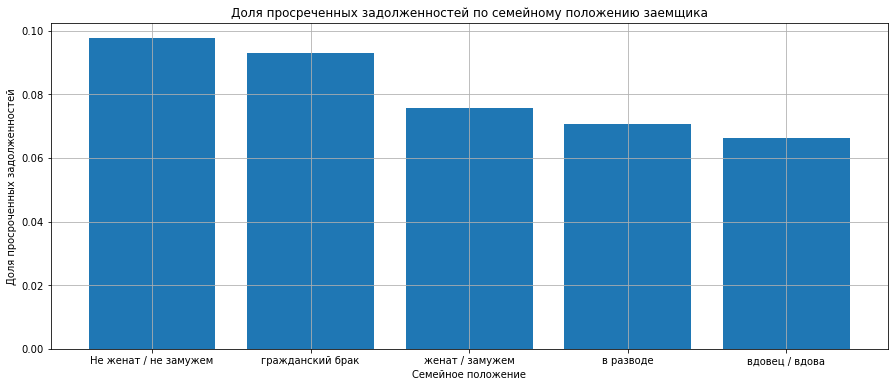

In [28]:
#построим график:
plt.figure(figsize=(15, 6))
plt.bar(data_pivot1['family_status'], data_pivot1['mean'])
plt.grid()
plt.title('Доля просреченных задолженностей по семейному положению заемщика')
plt.xlabel('Семейное положение')
plt.ylabel('Доля просроченных задолженностей');

**Вывод:** Больший риск невозврата кредита в срок наблюдается по двум категориям: для неженатых(незамужних) и для тех, кто состоит в гражданском браке.
Те, кто состоит или ранее состоял в браке, чаще возвращают кредит вовремя.

In [29]:
#Найдем долю просроченных задолженностей по каждой категории уровня дохода:
data_pivot2 = data.pivot_table(index=['total_income_category'], values="debt", aggfunc=['sum', 'count', 'mean'])
data_pivot2.columns = ['sum', 'count', 'mean']
data_pivot2 = data_pivot2.reset_index()
data_pivot2

,total_income_category,sum,count,mean
0,A,2,25,0.080000
1,B,354,5014,0.070602
2,C,1353,15938,0.084891
3,D,21,349,0.060172
4,E,2,22,0.090909


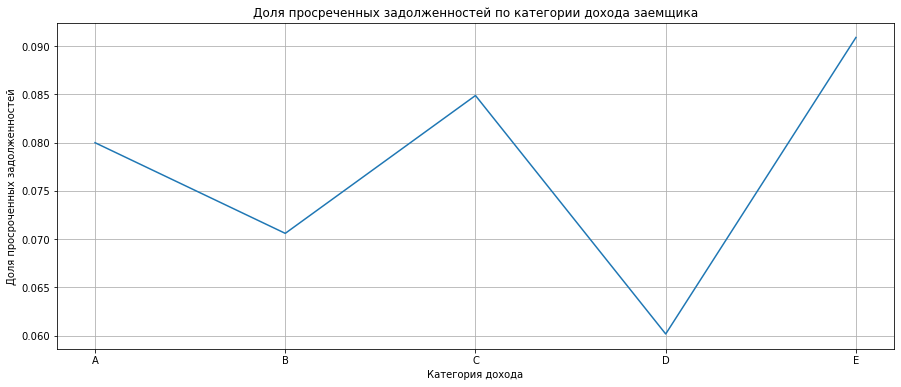

In [30]:
#построим график:
plt.figure(figsize=(15, 6))
plt.plot(data_pivot2['total_income_category'], data_pivot2['mean'])
plt.grid()
plt.title('Доля просреченных задолженностей по категории дохода заемщика')
plt.xlabel('Категория дохода')
plt.ylabel('Доля просроченных задолженностей');

**Вывод:** Явной зависимости риска невозврата кредита от уровня дохода нет.

In [31]:
#найдем долю просроченных задолженностей взависимости от цели кредита:
data_pivot3 = data.pivot_table(index=['purpose_category'], values="debt", aggfunc=['sum', 'count', 'mean'])
data_pivot3.columns = ['sum', 'count', 'mean']
data_pivot3 = data_pivot3.sort_values(by='mean', ascending=False).reset_index()
data_pivot3

,purpose_category,sum,count,mean
0,операции с автомобилем,400,4281,0.093436
1,получение образования,369,3989,0.092504
2,проведение свадьбы,183,2324,0.078744
3,операции с недвижимостью,780,10754,0.072531


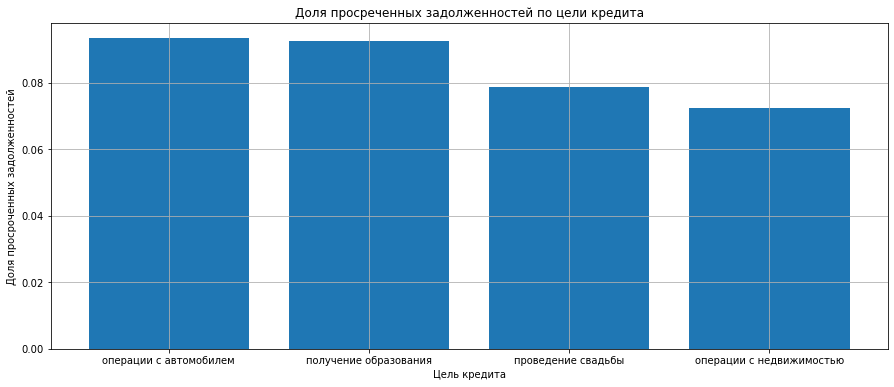

In [32]:
#построим график:
plt.figure(figsize=(15, 6))
plt.bar(data_pivot3['purpose_category'], data_pivot3['mean'])
plt.grid()
plt.title('Доля просреченных задолженностей по цели кредита')
plt.xlabel('Цель кредита')
plt.ylabel('Доля просроченных задолженностей');

**Вывод:** Кредиты, взятые на проведение свадьбы и операции с недвижимостью, отдают в срок чаще. Доля просроченных задолженностей больше в категориях операций с автомобилем и получения образования.

## Общий вывод.

На вероятность возврата кредита в срок влияет количество детей и семейное положение заемщика, а также цель, на которую был взят кредит:
* Чем больше детей у заемщика, тем выше вероятность невозврата кредита в срок.
* Те, кто никогда не состоял в официальном браке, чаще не возвращают кредит вовремя.
* Есть зависимость и от цели кредита: кредиты, взятые на операции с недвижимостью и проведение свадьбы, возвращают в срок чаще.